In [1]:
# Importing the libraries:
import tensorflow
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras_preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
print(os.listdir('D:\My_Interest\machine_learning\Personal_Projects\Cat_or_Dog_recognizer\dataset'))

['test', 'train']


In [3]:
# Defining the constants:
FAST_RUN=False
Image_width=128
Image_height=128
Image_size=(Image_width,Image_height)
Image_channels=3

In [4]:
# Prepare the training data:
filenames=os.listdir('D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\train')
categories=[]
for filename in filenames:
    category=filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
    
df=pd.DataFrame({
    'filename': filenames,
    'category': categories
    })

print(df.head())

print(df.tail())

       filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0
           filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1


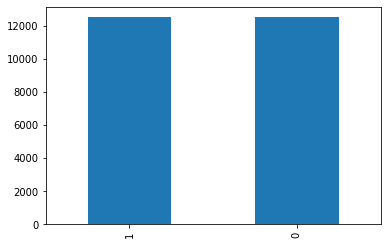

In [5]:
# Comparing the categories:
df['category'].value_counts().plot.bar()

In [6]:
# Building the model:

model=Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_width, Image_height, Image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [7]:
# Callbacks:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
earlystop=EarlyStopping(patience=10)
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',
                                          patience=2,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.0000001)

In [8]:
# Save the best model with the least validation loss:
checkpointer = ModelCheckpoint(filepath = "D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\Model\\model_weights.hdf5", verbose=1, save_best_only=True)

callbacks=[earlystop,learning_rate_reduction, checkpointer]

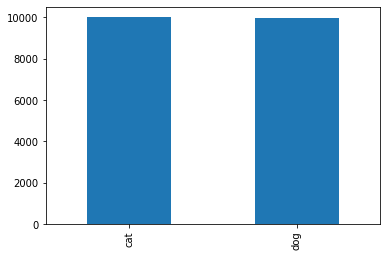

In [9]:
# Prepare the data:
df['category']=df['category'].replace({0:'cat', 1:'dog'})

train_df, validate_df=train_test_split(df, test_size=0.2, random_state=42)
train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)


train_df['category'].value_counts().plot.bar()

validate_df['category'].value_counts().plot.bar()

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [10]:
# Training generator:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [11]:
# Validation generator:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\train", 
    x_col='filename',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [12]:
# Fit model:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1333/1333 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.6323
Epoch 00001: val_loss improved from inf to 0.50823, saving model to D:\My_Interest\machine_learning\Personal_Projects\Cat_or_Dog_recognizer\Model\model_weights.hdf5
1333/1333 [==============================] - 1226s 920ms/step - loss: 0.7412 - accuracy: 0.6323 - val_loss: 0.5082 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7370
Epoch 00002: val_loss did not improve from 0.50823
1333/1333 [==============================] - 1146s 860ms/step - loss: 0.5411 - accuracy: 0.7370 - val_loss: 0.5753 - val_accuracy: 0.7499 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4905 - accuracy: 0.7706
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_loss did not i

Epoch 22/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2422 - accuracy: 0.8995
Epoch 00022: val_loss improved from 0.17580 to 0.16963, saving model to D:\My_Interest\machine_learning\Personal_Projects\Cat_or_Dog_recognizer\Model\model_weights.hdf5
1333/1333 [==============================] - 837s 628ms/step - loss: 0.2422 - accuracy: 0.8995 - val_loss: 0.1696 - val_accuracy: 0.9325 - lr: 3.1250e-05
Epoch 23/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2443 - accuracy: 0.8975
Epoch 00023: val_loss did not improve from 0.16963
1333/1333 [==============================] - 833s 625ms/step - loss: 0.2443 - accuracy: 0.8975 - val_loss: 0.1787 - val_accuracy: 0.9277 - lr: 3.1250e-05
Epoch 24/50
1333/1333 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.9004
Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00024: val_loss did not improve from 0.16963
1333/1333 [==============================]

In [18]:
# Save the model architecture as json file for future use:
model_json= model.to_json()
with open('D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\Model\\model.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
# Loading the model:

with open('D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\Model\\model.json', 'r') as json_file:
    json_savedModel= json_file.read()
    
# load the model architecture 
model = tensorflow.keras.models.model_from_json(json_savedModel)
model.load_weights('D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\Model\\model_weights.hdf5')
model.compile(loss="mean_squared_error", optimizer= 'rmsprop' , metrics = ['accuracy'])

In [15]:
# Prepare testing data:
test_filenames=os.listdir('D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\test')
test_df=pd.DataFrame({
    'filename': test_filenames
    })
nb_samples=test_df.shape[0]

In [16]:
# Create test generator:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [20]:
# PRedicting the result accuracy:
predict=model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
print('result : '+str(predict))

result : [[1.0477294e-03 9.9895227e-01]
 [1.1652994e-02 9.8834699e-01]
 [9.9702042e-01 2.9795591e-03]
 ...
 [9.9962568e-01 3.7432607e-04]
 [9.9257153e-01 7.4284677e-03]
 [6.7002261e-01 3.2997742e-01]]


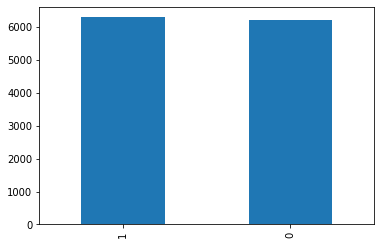

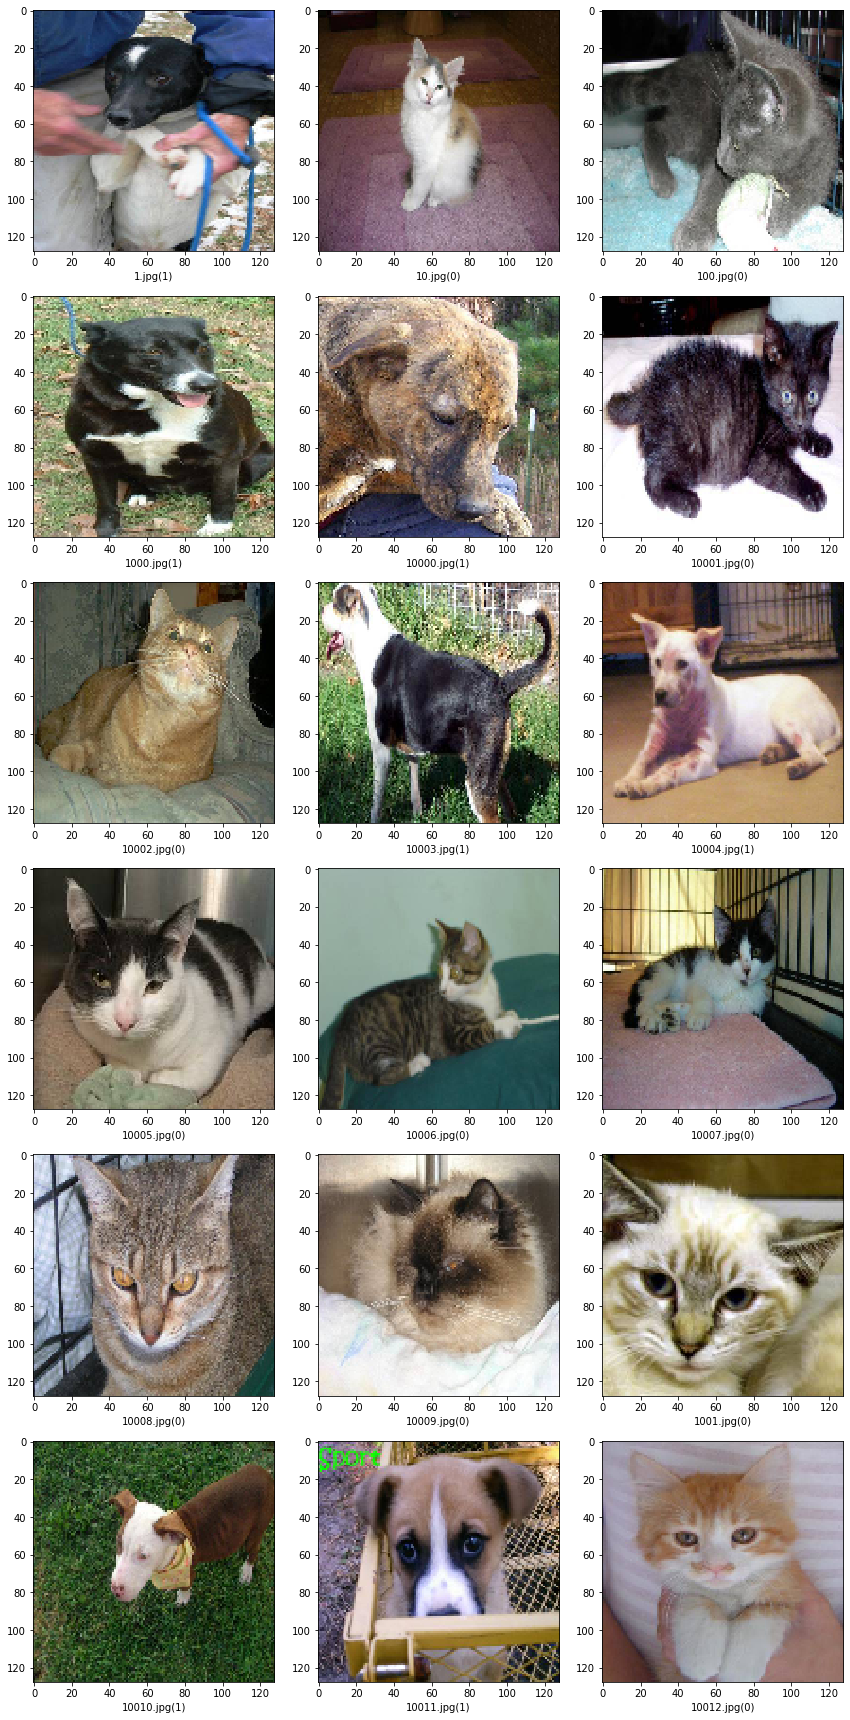

In [19]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

test_df['category'].value_counts().plot.bar()

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("D:\\My_Interest\\machine_learning\\Personal_Projects\\Cat_or_Dog_recognizer\\dataset\\test\\"+filename, target_size=Image_size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()